# Comparing discretization techniques

In Periodic problems and plane-wave discretizations we saw
how simple 1D problems can be modelled using plane-wave basis sets. This example
invites you to work out some details on these aspects yourself using a number of exercises.
The solutions are given at the bottom of the page.

For this example we consider the discretization of
$$
   H = - \frac12 Δ + V(x) \quad \text{with $V(x) = \cos(x)$}
$$
on $[0, 2π]$ with periodic boundary conditions. The $\cos(x)$ takes the role of
a lattice-periodic potential. We will be interested in the smallest eigenvalues
of this discretized Hamiltonian. Of note the boundary condition matters:
The spectrum we will get is different from e.g. the spectrum of $H$ on $\mathbb{R}$.

## Finite differences
We approximate functions $ψ$ on $[0, 2\pi]$ by their values at grid points
$x_k = 2\pi \frac{k}{N}$, $k=1, \dots, N$.
The boundary conditions are imposed by $ψ(x_0) = ψ(x_N), ψ(x_{N+1}) = ψ(x_1)$. We then have
$$
   \big(Hψ\big)(x_k) \approx \frac 1 2 \frac{-ψ_{k-1} + 2 ψ_k - ψ_{k+1}}{δx^2}
   + V(x_k) ψ(x_k)
$$
with $δx = \frac{2π}{N}$.

This can be put in matrix form in the following way:

In [1]:
# Finite differences Hamiltonian -1/2 Delta + V on [0, 2pi] with periodic bc.
# Pass it a function V.
using LinearAlgebra

function build_finite_differences_matrix(Vfunction, N::Integer)
    δx = 2π/N

    # Finite-difference approximation to -½Δ
    T = 1/(2δx^2) * Tridiagonal(-ones(N-1), 2ones(N), -ones(N-1))
    # The type Tridiagonal is efficient, but to establish the periodic boundary conditions
    # we need to add elements not on the three diagonals, so convert to dense matrix
    T = Matrix(T)
    T[1, N] = T[N, 1] = -1 / (2δx^2)

    # Finite-difference approximation to potential: We collect all coordinates ...
    x_coords = [k * δx for k=1:N]
    V = Diagonal(Vfunction.(x_coords))  # ... and evaluate V on each of the x_coords

    T + V
end;

> **Exercise 1**
>
> Show that the finite-difference approximation of -½Δ is indeed an
> approximation of the second derivative. Obtain an estimate of the first
> eigenvalue of $H$.
> *Hint:* Take a look at the `eigen` function from `LinearAlgebra`.

## Plane waves method

In this method, we expand states on the basis
$$
   e_G(x) = \frac{1}{\sqrt{2\pi}} e^{iGx} \qquad \text{for $G=-N,\dots,N$}.
$$

> **Exercise 2**
>
> Show that
> $$
>    \langle e_G, e_{G'}\rangle = ∫_0^{2π} e_G^\ast(x) e_{G'}(x) d x = δ_{G, G'}
> $$
> and (assuming $V(x) = \cos(x)$)
> $$
>    \langle e_G, H e_{G'}\rangle = \frac 1 2 \left(|G|^2 \delta_{G,G'} + \delta_{G, G'+1} + \delta_{G, G'-1}\right).
> $$
> What happens for a more general $V(x)$?

> **Exercise 3**
>
> Code this and check the first eigenvalue agrees
> with the finite-difference case. Compare accuracies at various basis set sizes $N$.

## Using DFTK

We now use DFTK to do the same plane-wave discretization in this 1D system.
To deal with a 1D case we use a 3D lattice with two lattice vectors set to zero.

In [2]:
using DFTK
a = 2π
lattice = a .* [[1 0 0.]; [0 0 0]; [0 0 0]];

Define Hamiltonian: Kinetic + Potential

In [3]:
terms = [Kinetic(),
         ExternalFromReal(r -> cos(r[1]))]  # r is a vector of size 3
model = Model(lattice; n_electrons=1, terms, spin_polarization=:spinless);  # One spinless electron

Ecut defines the number of plane waves by selecting all those $G$, which satisfy
the relationship $½ |G|^2 ≤ \text{Ecut}$.

In [4]:
Ecut = 500
basis = PlaneWaveBasis(model; Ecut, kgrid=(1, 1, 1))

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 2
    num. fft   threads   : 1

    Ecut                 : 500.0 Ha
    fft_size             : (135, 1, 1), 135 total points
    kgrid                : MonkhorstPack([1, 1, 1])
    num.   red. kpoints  : 1
    num. irred. kpoints  : 1

    Discretized Model(custom, 1D):
        lattice (in Bohr)    : [6.28319   , 0         , 0         ]
                               [0         , 0         , 0         ]
                               [0         , 0         , 0         ]
        unit cell volume     : 6.2832 Bohr
    
        num. electrons       : 1
        spin polarization    : spinless
        temperature          : 0 Ha
    
        terms                : Kinetic()
                               ExternalFromReal(Main.var"##243".var"#3#4"())

We now seek the ground state using the self-consistent field algorithm.

In [5]:
scfres = self_consistent_field(basis; tol=1e-4)
scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -0.535064852287                   -0.22   10.0    356ms
  2   -0.535064852288      -12.17       -0.91    1.0   51.3ms
  3   -0.535064852288      -14.48       -7.70    1.0    668μs


Energy breakdown (in Ha):
    Kinetic             0.2090845 
    ExternalFromReal    -0.7441493

    total               -0.535064852288

On this simple linear (non-interacting) model, the SCF converges in one step.
The ground state energy of is simply the lowest eigenvalue; it should match
the smallest eigenvalue of $H$ computed above.

## Plotting
We can also get the first eigenvector (in the plane wave basis) and plot it

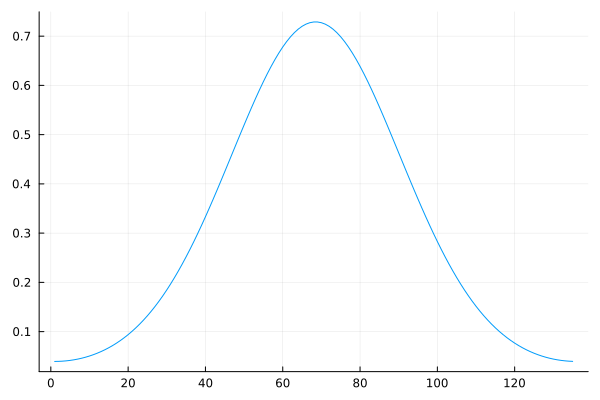

In [6]:
using Plots

ψ_fourier = scfres.ψ[1][:, 1];    # first k-point, all G components, first eigenvector
# Transform the wave function to real space
ψ = ifft(basis, basis.kpoints[1], ψ_fourier)[:, 1, 1]
# Eigenvectors are only defined up to a phase. We fix it by imposing that psi(0) is real
ψ /= (ψ[1] / abs(ψ[1]))
plot(real(ψ); label="")

Again this should match with the result above.

> **Exercise 4**
>
> Look at the Fourier coefficients of `ψ_fourier` and compare with the result above.

## The DFTK Hamiltonian
We can ask DFTK for the Hamiltonian

In [7]:
E, ham = energy_hamiltonian(basis, scfres.ψ, scfres.occupation; ρ=scfres.ρ)
H = ham.blocks[1]
typeof(H)

DFTK.DftHamiltonianBlock

This is an opaque data structure, which encodes the Hamiltonian. What can we do with it?

In [8]:
using InteractiveUtils
methodswith(typeof(H), supertypes=true)

[1] Array(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:75
[2] *(H::HamiltonianBlock, ψ) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:63
[3] (Matrix)(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:76
[4] eltype(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:64
[5] size(block::HamiltonianBlock, i::Integer) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:65
[6] size(block::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/terms/Hamiltonian.jl:66
[7] mul!(Hψ::AbstractArray, H::DFTK.DftHamiltonianBlock, ψ::AbstractArray) @ DFTK none:0
[8] PreconditionerNone(::HamiltonianBlock) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/eigen/preconditioners.jl:21
[9] PreconditionerTPA(ham::HamiltonianBlock; kwargs...) @ DFTK ~/work/DFTK.jl/DFTK.jl/src/eigen/preconditioners.jl:45

This defines a number of methods. For instance, it can be used as a linear operator:

In [9]:
H * DFTK.random_orbitals(basis, basis.kpoints[1], 1)

63×1 Matrix{ComplexF64}:
 0.016004108154627474 - 0.10140721827202112im
 -0.06496134897710476 - 0.05633454994541015im
 0.025760203850070818 - 0.18635915457238084im
  0.08195729191974079 + 0.03970940090969509im
  -0.6097389004761035 - 1.200656778207011im
  -0.2122376600186737 - 1.5215439852787884im
   0.9378615979714552 + 1.2218766461674677im
   -2.451521917207606 + 0.05253190517540529im
   -4.642166512157072 - 1.4679726350035236im
   0.8433476803101738 - 7.664994727863424im
                      ⋮
   1.3436124990637268 + 4.773348687184169im
   1.2378757287711601 + 2.8840002437867933im
  -0.7633068719851216 + 5.553058248105882im
   -0.802237173254034 - 1.2384546888947354im
 -0.30933084159070723 - 0.4379505860606466im
  0.36507856714699743 + 0.6954376036744173im
  0.16865780655571003 - 0.11400856451655161im
 -0.07604870945052836 - 0.21613070348280222im
 -0.13334067908561476 - 0.06879698533905698im

We can also get its full matrix representation:

In [10]:
Array(H)

63×63 Matrix{ComplexF64}:
  3.21245e-19+0.0im          …           0.5+9.98774e-18im
          0.5+9.98774e-18im      8.97271e-18+4.91711e-18im
  8.97271e-18+4.91711e-18im     -2.04669e-18+7.85756e-18im
 -2.04669e-18+7.85756e-18im     -1.01526e-17-1.97211e-17im
 -1.01526e-17-1.97211e-17im       1.0213e-17-1.52664e-17im
   1.0213e-17-1.52664e-17im  …   1.23204e-17-9.68665e-21im
  1.23204e-17-9.68665e-21im     -2.11585e-18+3.84134e-18im
 -2.11585e-18+3.84134e-18im     -8.22387e-18-4.9923e-19im
 -8.22387e-18-4.9923e-19im       4.20171e-18+1.36319e-18im
  4.20171e-18+1.36319e-18im     -1.03454e-17-1.16715e-17im
             ⋮               ⋱  
  4.20171e-18-1.36319e-18im      3.64735e-18+1.55332e-17im
  3.64735e-18+1.55332e-17im  …  -2.11585e-18-3.84134e-18im
 -2.11585e-18-3.84134e-18im      1.23204e-17+9.68665e-21im
  1.23204e-17+9.68665e-21im       1.0213e-17+1.52664e-17im
   1.0213e-17+1.52664e-17im     -1.01526e-17+1.97211e-17im
 -1.01526e-17+1.97211e-17im     -2.04669e-18-7.85756e-18i

> **Exercise 5**
>
> Compare this matrix `Array(H)` with the one you obtained in Exercise 3,
> get its eigenvectors and eigenvalues.
> Try to guess the ordering of $G$-vectors in DFTK.

> **Exercise 6**
>
> Increase the size of the problem, and compare the time spent
> by DFTK's internal diagonalization algorithms to a full diagonalization of `Array(H)`.
> *Hint:* The `@belapsed` and `@benchmark` macros
> (from the [BenchmarkTools](https://github.com/JuliaCI/BenchmarkTools.jl) package)
> are handy for this task. Note that there are some subtleties with global variables
> (see the BenchmarkTools docs for details). E.g. to use it to benchmark a function
> like `eigen(H)` run it as (note the `$`):
> ```julia
> using BenchmarkTools
> @benchmark eigen($H)
> ```

## Solutions

### Exercise 1
If we consider a function $f : [0, 2π] → \mathbb{R}$, to first order
$$
f(x + δx) = f(x) + δx f'(x) + O(δx^2)
$$
therefore after rearrangement
$$
f'(x) = \frac{f(x + δx) - f(x)}{δx} + O(δx).
$$
Similarly
$$
f''(x) = \frac{f'(x + δx) - f'(x)}{δx} + O(δx),
$$
such that overall
$$
f''(x) \simeq \frac{f(x + 2δx) - f(x + δx) - f(x + δx) + f(x)}{δx^2}
       = \frac{f(x + 2δx) - 2f(x + δx) + f(x)}{δx^2}
$$
In finite differences we consider a stick basis of vectors
$$
\left\{ e_i = (0, …, 0, \underbrace{δx}_\text{$i$-th position}, 0, …, 0)
        \middle| i = 1, … N \right\}.
$$
Keeping in mind the periodic boundary conditions (i.e. $e_0 = e_N$) projecting the
Hamiltonian $H$ onto this basis thus yields the proposed structure.

We start off with $N = 100$ to obtain

In [11]:
Hfd = build_finite_differences_matrix(cos, 100)
L, V = eigen(Hfd)
L[1:5]

5-element Vector{Float64}:
 -0.5351640695081414
  0.3429576842587494
  0.8532206682511969
  2.053679933442362
  2.078512110605267

This is already pretty accurate (to about 4 digits) as can be estimated looking at
the following convergence plot:

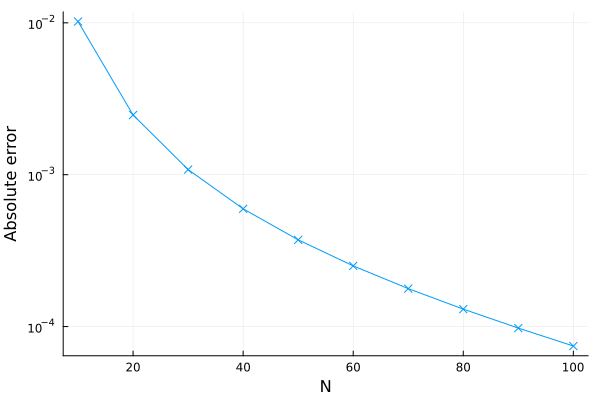

In [12]:
function fconv(N)
    L, V = eigen(build_finite_differences_matrix(cos, N))
    first(L)
end
Nrange = 10:10:100
plot(Nrange, abs.(fconv.(Nrange) .- fconv(200));
     yaxis=:log, legend=false, mark=:x, xlabel="N", ylabel="Absolute error")

### Exercise 2
- We note that
  $$
  \langle e_G, e_{G'}\rangle = ∫_0^{2π} e_G^\ast(x) e_{G'}(x) d x = 1/2π ∫_0^{2π} e^{i(G'-G)x} d x
  $$
  Since $e^{iy}$ is a periodic function with period $2\pi$, $\int_0^{2\pi} e^{i m y} = \delta_{0,m}$.
  Therefore if $G≠G'$ we have that $\langle e_G, e_{G'}\rangle = 0$,
  while $G=G'$ implies $\langle e_G, e_{G'}\rangle = 1$. In summary:
  $$
  \langle e_G, e_{G'}\rangle = δ_{G, G'}
  $$
- Next fo $V(x) = \cos(x)$ we obtain
  $$
  \langle e_G, H e_{G'}\rangle = \frac 1 2 ∫_0^{2π} e_G^\ast(x) H e_{G'}(x) d x
  $$
  We start by applying the Hamiltonian to a plane-wave:
  $$
  H e_{G'}(x) = - \frac 1 2 (-|G|^2) \frac 1 {\sqrt{2π}} e^{iG'x) + cos(x) \frac 1 {\sqrt{2π}} e{iG'x}
  $$
  Then, using the result of the first part of the exercise and the fact that
  $cos(x) = \frac 1 2 \left(e{ix} + e{-ix}\right)$, we get:
  $$
  \begin{align*}
  ⟨ e_G, H e_{G'}⟩
  &= \frac 1 2 G^2 δ_{G, G'} + \frac 1 {4π} \left(∫_0^{2π} e^{ix ⋅ (G'-G+1)} d x + ∫_0^{2π} e^{ix ⋅ (G'-G-1)} d x \right) \\
  &= \frac 1 2 \left(|G|^2 \delta_{G,G'} + \delta_{G, G'+1} + \delta_{G, G'-1}\right)
  \end{align*}
  $$
- In case a more general $V(x)$ was employed, this potential still has to be periodic
  over $[0, 2\pi]$ to fit our setting. Assuming sufficient regularity in $V$ we can employ
  a Fourier series:
  $$
  V(x) = \sum_{G=- \infty}^{\infty} \hat{V}_G e_G(x)
  $$
  where
  $$
  \hat{V}_G = \frac{1}{\sqrt{2π}} ∫_0^{2π} V(x) e^{-iGx} dx = ∫_0^{2π} V(x) e_G^\ast dx .
  $$
  Note that one can change of this as a change of basis
  from the position basis to the plane-wave basis.

  Based on this expansion
  $$
  \begin{align*}
  ⟨ e_G, V e_{G'} ⟩ &= \left\langle e_G, ∑_{G''} \hat{V}_{G''} \, e_{G'+G''} \right\rangle \\
  &= \sum_{G''=-\infty}^\infty \hat{V}_{G''} ⟨ e_G, e_{G'+G''} ⟩ \\
  &= \sum_{G''=-\infty}^\infty \hat{V}_{G''} \, δ_{G-G', G''} ⟩ \\
  &= \hat{V}_{G-G'}
  \end{align*}
  $$
  and therefore
  $$
  ⟨ e_G, H e_{G'} ⟩ = \frac 1 2 |G|^2 \delta_{G,G'} + \hat{V}_{G-G'},
  $$
  i.e. essentially the Fourier transform of $V$ determines the contribution
  to the matrix elements of the Hamiltonian.


### Exercise 3
The Hamiltonian matrix for the plane waves method can be found this way:

In [13]:
# Plane waves Hamiltonian -½Δ + cos on [0, 2pi].
function build_plane_waves_matrix_cos(N::Integer)
    # Plane wave approximation to -½Δ
    Gsq = [float(i)^2 for i in -N:N]
    # Hamiltonian as derived in Exercise 2:
    1/2 * Tridiagonal(ones(2N), Gsq, ones(2N))
end;

Then we check that the first eigenvalue agrees with the finite-difference case, using $N = 10$:

In [14]:
Hpw_cos = build_plane_waves_matrix_cos(10)
L, V = eigen(Hpw_cos)
L[1:5]

5-element Vector{Float64}:
 -0.5350648522878154
  0.34336012839908336
  0.8536343543207997
  2.0565044112660984
  2.081227363352144

We look at the convergence plot to compare the accuracy for various numbers of plane-waves $N$:

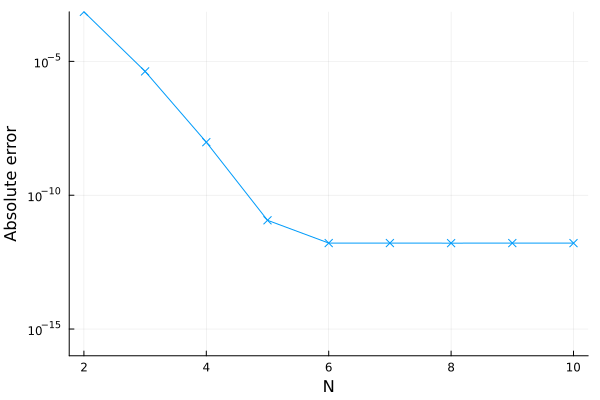

In [15]:
function fconv(N)
    L = eigvals(build_plane_waves_matrix_cos(N))
    first(L)
end

Nrange = 2:10
plot(Nrange, abs.(fconv.(Nrange) .- fconv(200)); yaxis=:log, legend=false,
     ylims=(1e-16,Inf), ylabel="Absolute error", xlabel="N", mark=:x)

Notice how compared to exercise 1 the considered basis size $N$ is much smaller,
indicating that plane-wave methods more quickly lead to accurate solutions than
finite-difference methods.

### Exercise 4
For efficiency reasons the data in Fourier space is not ordered increasingly with $G$.
Therefore to plot the Fourier space representation sensibly, we need to sort by ascending
values of the $G$ vectors first. For this we extract the Fourier vector of each plane-wave
basis function in the index order:

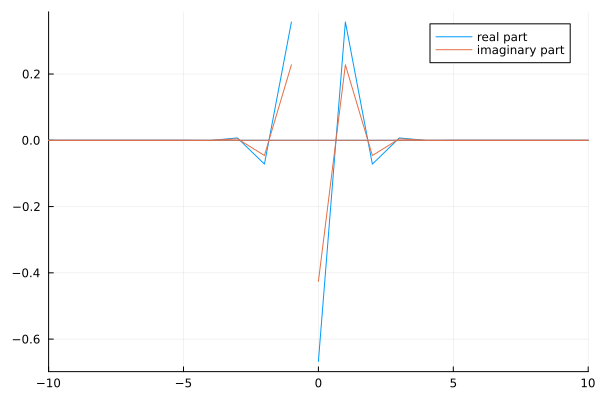

In [16]:
coords_G_vectors = G_vectors_cart(basis, basis.kpoints[1])  # Get coordinates of first and only k-point

# Only keep first component of each vector (because the others are zero for 1D problems):
coords_Gx = [G[1] for G in coords_G_vectors]

p = plot(coords_Gx, real(ψ_fourier); label="real part", xlims=(-10, 10))
plot!(p, coords_Gx, imag(ψ_fourier); label="imaginary part")

The plot is symmetric about the zero (confirming that the orbitals are real)
and only takes peaked values, which corresponds
to the expected result for a cosine potential.

### Exercise 5
To figure out the ordering we consider a small basis and build the Hamiltonian:

In [17]:
basis_small  = PlaneWaveBasis(model; Ecut=5, kgrid=(1, 1, 1))
ham_small = Hamiltonian(basis_small)
H_small = Array(ham_small.blocks[1])
H_small[abs.(H_small) .< 1e-12] .= 0  # Drop numerically zero entries
H_small

7×7 Matrix{ComplexF64}:
 0.0+0.0im          0.5+1.00424e-16im  …  0.5-1.00424e-16im
 0.5-1.00424e-16im  0.5+0.0im             0.0+0.0im
 0.0+0.0im          0.5-1.00424e-16im     0.0+0.0im
 0.0+0.0im          0.0+0.0im             0.0+0.0im
 0.0+0.0im          0.0+0.0im             0.0+0.0im
 0.0+0.0im          0.0+0.0im          …  0.5+1.00424e-16im
 0.5+1.00424e-16im  0.0+0.0im             0.5+0.0im

The equivalent version using the `build_plane_waves_matrix_cos` function
is `N=3` (both give rice to a 7×7 matrix).

In [18]:
Hother = build_plane_waves_matrix_cos(3)

7×7 LinearAlgebra.Tridiagonal{Float64, Vector{Float64}}:
 4.5  0.5   ⋅    ⋅    ⋅    ⋅    ⋅ 
 0.5  2.0  0.5   ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.5  0.5  0.5   ⋅    ⋅    ⋅ 
  ⋅    ⋅   0.5  0.0  0.5   ⋅    ⋅ 
  ⋅    ⋅    ⋅   0.5  0.5  0.5   ⋅ 
  ⋅    ⋅    ⋅    ⋅   0.5  2.0  0.5
  ⋅    ⋅    ⋅    ⋅    ⋅   0.5  4.5

By comparing the entries we find the ordering is 0,1,2,...,-2,-1,
which can also be found by inspecting

In [19]:
first.(G_vectors(basis_small, basis_small.kpoints[1]))

7-element Vector{Int64}:
  0
  1
  2
  3
 -3
 -2
 -1

Both matrices have the same eigenvalues:

In [20]:
maximum(abs, eigvals(H_small) - eigvals(Hother))

1.7763568394002505e-15

and in the eigenvectors we find the same rearrangements in the entries
of the eigenvectors of both matrices, matching the DFTK ordering of
is 0,1,2,...,-2,-1.

In [21]:
eigvecs(Hother)[:, 1]

7-element Vector{Float64}:
 -0.008461095314567344
  0.08520425570524764
 -0.42353481192309905
  0.7915641575577494
 -0.42353481192310566
  0.08520425570524905
 -0.008461095314567471

In [22]:
eigvecs(H_small)[:, 1]

7-element Vector{ComplexF64}:
  -0.7915641575577493 + 1.5898485476322146e-16im
  0.42353481192310877 - 1.7013307112974292e-16im
 -0.08520425570525011 + 5.1339563909648e-17im
 0.008461095314567624 - 6.797609502050578e-18im
 0.008461095314567069 + 3.3988047510250303e-18im
 -0.08520425570524359 - 1.711318796988132e-17im
   0.4235348119230965 + 0.0im

Notice, that eigenvectors are only defined up to a phase, so the
sign may globally be inverted between the two eigenvectors.

### Exercise 6

We benchmark the time needed for a full diagonalization (instantiation of the Array
plus call of `eigen`) versus the time needed for running the SCF (i.e. iterative
diagonalization using plane waves).

In [23]:
using Printf

for Ecut in 200:200:1600
   basis_time = PlaneWaveBasis(model; Ecut, kgrid=(1, 1, 1))
   t_eigen = @elapsed eigen(Array(Hamiltonian(basis_time).blocks[1]))
   t_scf   = @elapsed self_consistent_field(basis_time; tol=1e-6, callback=identity);
   @printf "%4i  eigen=%8.4fms  scf=%8.4fms\n" Ecut 1000t_eigen 1000t_scf
end

 200  eigen=182.1207ms  scf=175.0675ms
 400  eigen=  3.9153ms  scf=  3.6600ms
 600  eigen=  5.9348ms  scf=  3.9330ms
 800  eigen=  9.7018ms  scf=  4.1061ms
1000  eigen= 11.4075ms  scf=  4.5248ms
1200  eigen= 14.0039ms  scf=  4.5830ms
1400  eigen= 16.0738ms  scf=  4.7163ms
1600  eigen= 19.1123ms  scf=  4.6516ms
